In [1]:
import discretize
from discretize import utils
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.constants import mu_0
from pymatsolver import Pardiso
import time

from SimPEG.EM import TDEM
from SimPEG import Utils, Maps, versions

In [2]:
target_mur = 100  # permeability of the target
target_l = 200  # length of target
target_r = 50  # radius of the target
target_top = -50

sigma_back = 1e-5  # conductivity of the background

dipole_z = np.r_[-82.5, -12.5] 
# radius_loop = 100  # radius of the transmitter loop

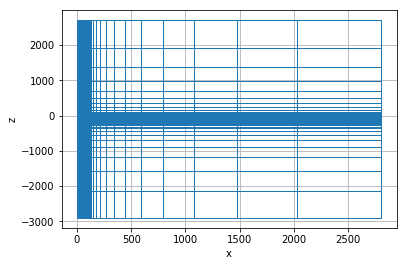

In [3]:
csx = 5.  # core cell size in the x-direction
csz = 5.  # core cell size in the z-direction
domainx = 100  # use a uniform cell size out to a radius of 100m

# padding parameters
npadx, npadz = 15, 15  # number of padding cells
pfx = 1.4  # expansion factor for the padding to infinity in the x-direction
pfz = 1.4  # expansion factor for the padding to infinity in the z-direction

ncz = int(target_l/csz)  # number of z cells in the core region

# create the cyl mesh
mesh = discretize.CylMesh([
    [(csx, int(domainx/csx)), (csx, npadx, pfx)],
    1,
    [(csz, npadz, -pfz), (csz, ncz), (csz, npadz, pfz)]
])

# put the origin at the top of the target
mesh.x0 = [0, 0, -mesh.hz[:npadz + ncz].sum()]

# plot the mesh
mesh.plotGrid()

In [4]:
mur_model = np.ones(mesh.nC)

# find the indices of the target
x_inds = mesh.gridCC[:, 0] < target_r
z_inds = (mesh.gridCC[:, 2] <= target_top) & (mesh.gridCC[:, 2] >= target_top-target_l)

mur_model[x_inds & z_inds] = target_mur
mu_model = mu_0 * mur_model

sigma = np.ones(mesh.nC) * sigma_back

In [5]:
src_inds = (mesh.gridFz[:, 0] < csx) & (mesh.gridFz[:, 2] <= dipole_z[1]) & (mesh.gridFz[:, 2] >= dipole_z[0]) 

(-300.0, 10.0)

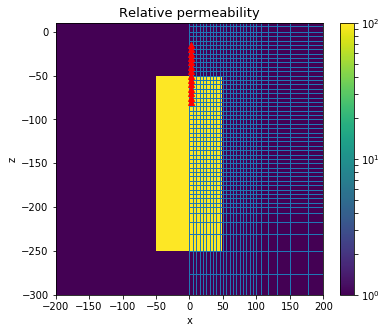

In [6]:
xlim = np.r_[-200, 200]  # x-limits in meters
zlim = np.r_[-1.5*target_l, 10.]  # z-limits in meters. (z-positive up)

fig, ax = plt.subplots(1, 1, figsize=(6, 5))

# plot the permeability
plt.colorbar(mesh.plotImage(
    mur_model, ax=ax,
    pcolorOpts={'norm': LogNorm()},  # plot on a log-scale
    mirror=True
)[0], ax=ax)
mesh.plotGrid(ax=ax)
ax.grid(False)
ax.plot(mesh.gridFz[src_inds, 0], mesh.gridFz[src_inds, 2], 'r^')


ax.set_title("Relative permeability", fontsize=13)
ax.set_xlim(xlim)
ax.set_ylim(zlim)

In [7]:
s_e = np.zeros(mesh.nFz)
s_e[src_inds] = 1
s_e = np.hstack([np.zeros(mesh.vnF[:2].sum()), s_e])

Text(0.5,1,'quarter sine waveform')

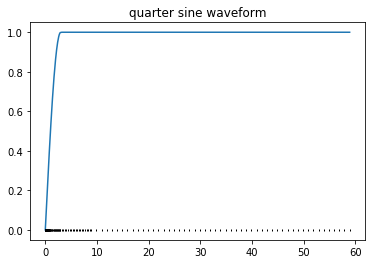

In [8]:
ramp = [
    (1e-5, 20), (1e-4, 20), (3e-4, 20), (1e-3, 20), (3e-3, 20), (1e-2, 20),
    (3e-2, 20), (1e-1, 20), (3e-1, 20), (1,  50)
]
time_mesh = discretize.TensorMesh([ramp])

# define an off time past when we will simulate to keep the transmitter on
offTime = 100
quarter_sine = TDEM.Src.QuarterSineRampOnWaveform(
    ramp_on=np.r_[0., 3], ramp_off= offTime - np.r_[1., 0]
)

# evaluate the waveform at each time in the simulation
quarter_sine_plt = [quarter_sine.eval(t) for t in time_mesh.gridN]

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(time_mesh.gridN, quarter_sine_plt)
ax.plot(time_mesh.gridN, np.zeros(time_mesh.nN), 'k|', markersize=2)
ax.set_title('quarter sine waveform')

In [9]:
src_ramp_on = TDEM.Src.RawVec_Grounded([], s_e, waveform=quarter_sine)
src_mmr = TDEM.Src.RawVec_Grounded([], s_e)

In [10]:
prob_mmr = TDEM.Problem3D_h(
    mesh=mesh, sigmaMap=Maps.IdentityMap(mesh), timeSteps=ramp,
    Solver=Pardiso
)
prob_ramp_on = TDEM.Problem3D_h(
    mesh=mesh, sigmaMap=Maps.IdentityMap(mesh), timeSteps=ramp,
    Solver=Pardiso
)

survey_mmr = TDEM.Survey(srcList=[src_mmr])
survey_ramp_on = TDEM.Survey([src_ramp_on])

prob_mmr.pair(survey_mmr)
prob_ramp_on.pair(survey_ramp_on)

In [11]:
t = time.time()
print('--- Running Long On-Time Simulation ---')

prob_ramp_on.mu = mu_model
fields = prob_ramp_on.fields(sigma)

print(" ... done. Elapsed time {}".format(time.time() - t))
print('\n')

# grab the last time-step in the simulation
h_ramp_on = utils.mkvc(fields[:, 'h', -1])

--- Running Long On-Time Simulation ---
 ... done. Elapsed time 0.4422478675842285




In [12]:
prob_mmr.mu = mu_model
prob_mmr.model = sigma
h_mmr = src_mmr.hInitial(prob_mmr)

In [13]:
def plotHFieldResults(
    ax=None, clim_min=None, clim_max=None,
    max_depth=1.5*target_l, max_r=100,
    top=10., view="mmr"
):
    if ax is None:
        plt.subplots(1, 1, figsize=(6, 7))

    assert view.lower() in ["mmr", "late_ontime", 'diff']

    xlim = max_r*np.r_[-1, 1]  # x-limits in meters
    zlim = np.r_[-max_depth, top]  # z-limits in meters. (z-positive up)

    clim = None

    if clim_max is not None and clim_max != 0.:
        clim = clim_max * np.r_[-1, 1]

        if clim_min is not None and clim_min != 0.:
            clim[0] = clim_min

#     pltmesh = discretize.TensorMesh([mesh.hx, mesh.hz], x0=mesh.x0[[0, 2]])
    if view == "mmr":
        plotme = h_mmr
    elif view == "late_ontime":
        plotme = h_ramp_on
    elif view == "diff":
        plotme = h_mmr-h_ramp_on

    cb = plt.colorbar(mesh.plotImage(
        mesh.aveE2CCV * plotme,
        vType='CC',
        ax=ax, range_x=xlim, range_y=zlim,
        sample_grid=np.r_[np.diff(xlim)/100., np.diff(zlim)/100.],
        mirror=True,
#         pcolorOpts={'norm': LogNorm()}
    )[0], ax=ax)
    cb.set_clim(clim)
    ax.set_title('{}'.format(view), fontsize=13)
    ax.set_xlim(xlim)
    ax.set_ylim(zlim)
    cb.update_ticks()

    return ax

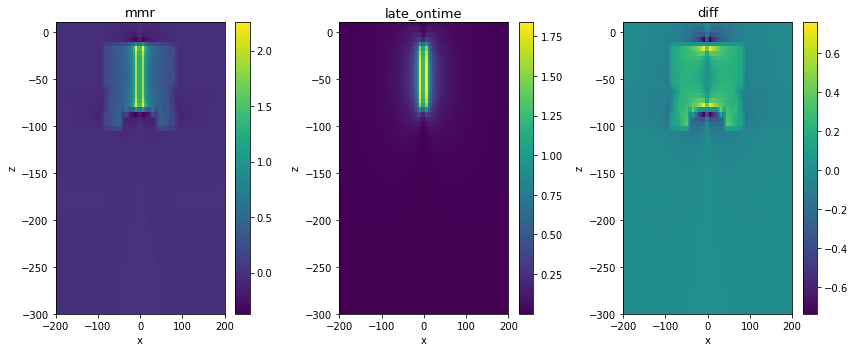

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))

for a, v in zip(ax, ["mmr", "late_ontime", "diff"]):
    a = plotHFieldResults(
        ax=a,
#         clim_min=1e-15,
#         clim_max=1e-7,
        view=v,
        max_r=200
    )
plt.tight_layout()